Input -> Calculate forces and integrate equations of motion -> perform P, control T if necessary -> t = t + deltT -> Calculate and update the molecule position (-> t<tmax back to the calcualte forces tab) -> Output: key output is a trajectory file with positions at a given time, here the thermodynamics and transport properties are determined....

Sigma is the diameter of atom and epsilon is the energy of the particle

In order to control reaction in terms of energy, need to completely isolate the system. This is not physically 100% possible. Come with a theoretical limit. 

If try to determine a parameter, do not use the equilibration zone

Limitations - not considering rotational or vibrational energy

CE40248 Coursework: Molecular Dynamics
Author: Alex Pooley
Date edited: 27/10/2025
Description: Code takes a series of parameters within a system and using the Lennard-Jones potential, calculates force and velocity to create a file of positions in space, for each molecule for each time step.

In [2]:
# Import packages needed
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import csv

INSERT LJ EQUATIONS

The Mie-SAFT correlation is used to determine potential energy due to attraction and repulsion within the system. PUT IN TEH IF

$$U(r) = 
\begin{cases} 
C \epsilon \left[ \left(\left(\frac{\sigma}{r}\right)^{\lambda_r} - \left(\frac{\sigma}{r}\right)^6\right) - \left(\left(\frac{\sigma}{r_c}\right)^{\lambda_r} - \left(\frac{\sigma}{r_c}\right)^6\right) \right] & \text{if } r < r_c \\ 
0 & \text{if } r \ge r_c 
\end{cases}$$
$$ \text{Where } C =  \left( \frac{\lambda_r}{\lambda_r - 6} \right) \left( \frac{\lambda_r}{6} \right)^\beta \quad \text{and where} \quad \beta = \left( \frac{6}{\lambda_r - 6} \right)$$

Furthermore, the potential energy equation is differentiated with respect to radius forming a force vector equation as a function of radius. As the energy due to cut off is constant, the term is set to 0. This can be seen below:

$$
F(r) = \frac{\epsilon C}{r} 
\left[ 
\lambda_r \left( \frac{\sigma^{\lambda_r}}{r^{\lambda_r + 1}} \right) 
- 6 \left( \frac{\sigma^6}{r^{7}} \right) 
\right]
$$

Where $U(r)$ is the mie potential energy [J], $r$ is the interparticle distance (radius) [m], $\epsilon$ is the potential energy well depth [J], $\sigma$ is the distance where the potential energy $U(r)$ is zero [m], $\lambda_r$ is the repulsive exponent [Dimensionless], $C$ is the pre-factor constant [Dimensionless], $\beta$ is the exponent used in $C$ [Dimensionless], $F(r)$ is the force as a function of distance [N].



In [3]:
# SAFT Mie Correlation

def U_SAFT(r, sigma, epsilon, lambda_r): 
    # Function to calculate potential energy, using Mie-SAFT potential equation
    beta = 6 / (lambda_r - 6) # Calculaets the beta exponent
    C = (lambda_r/(lambda_r - 6)) * ((lambda_r / 6)**beta) # Calculate the C prefactor
    U = C * epsilon * ((sigma / r)**lambda_r - (sigma / r)**6) # Potential energy calculation
    
    return U 

def F_SAFT(r, sigma, epsilon, lambda_r):
    # Function to calculate the force using the negative differential of the SAFT-Mie equation
    beta = 6.0 / (lambda_r - 6.0) # Calculate the beta exponent
    C = (lambda_r / (lambda_r - 6.0)) * ((lambda_r / 6.0) ** beta) #Calculate the C prefactor

    sr_lambda = (sigma / r) ** lambda_r
    sr6 = (sigma / r) ** 6.0
    F_over_r = C * epsilon * (lambda_r * sr_lambda - 6.0 * sr6) / (r * r) # Force vector over r so only need to be *rij

    return F_over_r


In order to mimic the bulk system, partial boundary conditions are used. When a particle tries to leave the box, the psoition vector is mirrored to the opoosite side. This creates an infinite system of symmetrical parts to be used in thermophyscial property determination.

$$\vec{r}_{\text{wrapped}} = \vec{r} - L \lfloor \vec{r} / L \rfloor$$

The minimum image convention must be considered when determining interactions, this means that the particel interacts with the nearest particle to it, even if it does not exist explicitly within the defined box.

$$\vec{r}_{ij, \text{mic}} = \vec{r}_{ij} - L \cdot \text{round}(\vec{r}_{ij} / L)$$


In [4]:
# Periodic Boundary Conditions and Minimum Image Convention

def pbc_wrap(pos, L):
    # Function to wrap particle around the box if the particle flies out, mimics bulk flow now
    new_pos = pos -L * np.floor(pos / L) # Called if out of the box and position is flipped to oppostie side
    
    return new_pos

def MIC(vec, L):
    # Function to ensure behaviour of bulk flow matched to simulation by ensuring the distance is the actual distance, not the distance after the pbc applied
    mic = vec - L * np.round(vec / L) # CHECK
    
    return mic

In [5]:
# Vertlet neighbour and cell neightbour listing 

def build_neighbour_list(positions, L, rc_list, bond_set):
   
    N = positions.shape[0]
    nlist = [[] for _ in range (N)] # Intialise an empty neighbour list
    rc_sq = rc_list**2
    
    for i in range (N-1): # Compute pairwise displacement vectors
        rij = positions[i+1:] - positions[i]  # Find distance between each mol
        rij = MIC(rij, L)                     # Apply mic...
        dist2 = np.sum(rij*rij, axis=1)       # Calculate the squared distances
        mask = dist2 < rc_sq            # If distance below cut off, take into account
        js = np.nonzero(mask)[0] + (i + 1)
        
        for j in js:
            
        #5. The Critical Bond Check
            if (i, j) in bond_set or (j, i) in bond_set:
                continue # Skip this pair, they are bonded

           # 6. Add to List
            nlist[i].append(j) 
    
    return nlist

def build_neighbour_listcellnah(positions, L, rc_list, bond_set):
    """
    Builds a HALF neighbor list (j > i) using an O(N) cell list algorithm.
    The output is identical in format to the original O(N^2) function.
    
    Args:
        positions (array): (N_beads, 3) particle positions.
        L (float): Box length.
        rc_list (float): Cutoff radius for the neighbor list.
        bond_set (set): Set of bonded pairs (i, j) to exclude.
        
    Returns:
        list: A half neighbor list, where nlist[i] = [neighbors j, j > i].
    """
    
    N = positions.shape[0]
    nlist = [[] for _ in range(N)]
    rc_sq = rc_list**2
    
    # --- 1. Chop the Box: Create the Cell Grid ---
    
    # We must make cells *at least* rc_list wide.
    n_cells_per_dim = max(1, int(np.floor(L / rc_list)))
    
    # Calculate the actual length of each cell
    cell_length = L / n_cells_per_dim
    
    # --- 2. Sort Particles into Cells (The "Roster") ---
    cells = {}
    for i in range(N):
        pos = positions[i]
        
        # Find the 3D cell index for particle i
        # The modulo handles the L boundary case
        cx = int(np.floor(pos[0] / cell_length)) % n_cells_per_dim
        cy = int(np.floor(pos[1] / cell_length)) % n_cells_per_dim
        cz = int(np.floor(pos[2] / cell_length)) % n_cells_per_dim
        key = (cx, cy, cz)
        
        if key not in cells:
            cells[key] = []
        cells[key].append(i)
            
    # --- 3. Find Neighbors (The "Check") ---
    
    # Now, loop over every particle 'i'
    for i in range(N):
        pos_i = positions[i]
        
        # Find which cell 'i' lives in
        cx = int(np.floor(pos_i[0] / cell_length)) % n_cells_per_dim
        cy = int(np.floor(pos_i[1] / cell_length)) % n_cells_per_dim
        cz = int(np.floor(pos_i[2] / cell_length)) % n_cells_per_dim
        
        # Loop over its own cell and all 26 neighboring cells
        for dcx in [-1, 0, 1]:
            for dcy in [-1, 0, 1]:
                for dcz in [-1, 0, 1]:
                    
                    # Find the 3D index of the neighbor cell
                    ncx = (cx + dcx) % n_cells_per_dim
                    ncy = (cy + dcy) % n_cells_per_dim
                    ncz = (cz + dcz) % n_cells_per_dim
                    nkey = (ncx, ncy, ncz)
                    
                    if nkey not in cells:
                        continue
                        
                    # Loop over all particles 'j' in that cell
                    for j in cells[nkey]:
                        
                        # --- This ensures we build a HALF LIST (j > i) ---
                        if i >= j:
                            continue
                            
                        # --- Standard Check ---
                        rij = pos_i - positions[j]
                        rij = MIC(rij, L)
                        dist2 = np.sum(rij*rij)
                        
                        if dist2 < rc_sq:
                            # Check if they are bonded
                            if (i, j) in bond_set or (j, i) in bond_set:
                                continue
                            
                            # --- THE FIX ---
                            # Add 'j' to 'i's list
                            nlist[i].append(j)
                            # We DO NOT add nlist[j].append(i)
                                
    return nlist

In [6]:
from numba import jit

@jit(nopython=True)
def _get_cell_idx(pos, cell_length, n_cells_per_dim):
    """(Numba-jitted) Gets the 1D cell index from a 3D position."""
    # Find 3D cell index (cx, cy, cz)
    cx = int(np.floor(pos[0] / cell_length)) % n_cells_per_dim
    cy = int(np.floor(pos[1] / cell_length)) % n_cells_per_dim
    cz = int(np.floor(pos[2] / cell_length)) % n_cells_per_dim
    
    # Convert 3D index to a 1D index
    return cx + cy * n_cells_per_dim + cz * (n_cells_per_dim**2)

@jit(nopython=True)
def _build_cell_list_data(positions, L, rc_list, N):
    """
    (Numba-jitted) Creates the 'head' and 'tail' arrays for 
    a linked-list cell list. O(N) operation.
    """
    n_cells_per_dim = max(1, int(np.floor(L / rc_list)))
    cell_length = L / n_cells_per_dim
    n_cells_total = n_cells_per_dim**3
    
    # 'head' stores the ID of the *first* particle in each cell
    head = -np.ones(n_cells_total, dtype=np.int32)
    # 'tail' stores the ID of the *next* particle in the same cell
    tail = -np.ones(N, dtype=np.int32)
    
    # Loop over all particles (O(N))
    for i in range(N):
        # Find which cell particle 'i' belongs to
        cell_idx = _get_cell_idx(positions[i], cell_length, n_cells_per_dim)
        
        # --- Create the Linked List ---
        # 1. 'tail[i]' points to the particle that was *previously*
        #    the first one in this cell (or -1 if none).
        tail[i] = head[cell_idx]
        
        # 2. 'head[cell_idx]' is updated to point to our new particle 'i'.
        head[cell_idx] = i
        
    return head, tail, n_cells_per_dim, cell_length

def build_neighbour_listcell(positions, L, rc_list, bond_set):
    """
    Builds a HALF neighbor list (j > i) using a fast, Numba-accelerated
    O(N) cell list algorithm.
    """
    N = positions.shape[0]
    nlist = [[] for _ in range(N)]
    rc_sq = rc_list**2

    # --- 1. Build the fast cell list data (O(N), Jitted) ---
    head, tail, n_cells_per_dim, cell_length = _build_cell_list_data(
        positions, L, rc_list, N
    )

    # --- 2. Find Neighbors (O(N), but in Python) ---
    for i in range(N):
        pos_i = positions[i]
        
        # Get the 3D cell index of particle i
        cx = int(np.floor(pos_i[0] / cell_length)) % n_cells_per_dim
        cy = int(np.floor(pos_i[1] / cell_length)) % n_cells_per_dim
        cz = int(np.floor(pos_i[2] / cell_length)) % n_cells_per_dim

        # Loop over its own cell and 26 neighbors
        for dcx in [-1, 0, 1]:
            for dcy in [-1, 0, 1]:
                for dcz in [-1, 0, 1]:
                    ncx = (cx + dcx) % n_cells_per_dim
                    ncy = (cy + dcy) % n_cells_per_dim
                    ncz = (cz + dcz) % n_cells_per_dim
                    
                    # Get 1D cell index
                    cell_idx = ncx + ncy * n_cells_per_dim + ncz * (n_cells_per_dim**2)
                    
                    # Get the ID of the first particle 'j' in this cell
                    j = head[cell_idx]
                    
                    # Loop through all particles 'j' in this cell
                    # by following the 'tail' (linked list)
                    while j != -1:
                        
                        # --- Build Half List (j > i) ---
                        # This is the same logic as your original function
                        if i >= j:
                            j = tail[j] # Go to next particle in cell
                            continue
                            
                        # --- Standard Check ---
                        rij = pos_i - positions[j]
                        rij = MIC(rij, L)
                        dist2 = np.sum(rij*rij)
                        
                        if dist2 < rc_sq:
                            if (i, j) not in bond_set and (j, i) not in bond_set:
                                nlist[i].append(j)
                        
                        j = tail[j] # Go to next particle in cell
                                
    return nlist

INSERT THE NEIGHBOUR LIST MATHS AND POTENTIALLY THE CELL LIST MATH IF USED

In [7]:
def compute_forces(positions, rc, nlist, L, bead_particle_type, masses, sigma_matrix, epsilon_matrix, lambda_matrix, Urc_matrix): # COMPUTES THE FORCES ON EACH BEAD!!!!!!!!!!!
    # Function to determine the forces acting on each moleucle due to each 
    # interaction, if within distance applicable to LJ.
    
    N = positions.shape[0]            # Gets number of particles from the positions array - 34 in this case for 27 particels as the 7 po have 2 beads
    forces = np.zeros_like(positions) # Makes a matrix the same size as positions for forces in each direction - 34
    
    LJ_pot = 0.0
    potential = 0.0 # Set the potential energy to zero
    virial = 0.0    # Initialise the virial coefficient
    
    # Following loop takes into account every interaction possible. i and j represent a different particle every loop
    for i in range(N - 1): # One less that the total number of particles (as each particle cannot interact with itself)
        type_i = bead_particle_type[i]
        
        
        for j in nlist[i]: # For particle i, work interaction to every other particle
            type_j = bead_particle_type[j]
            sigma = sigma_matrix[type_i, type_j]
            epsilon = epsilon_matrix[type_i, type_j]
            lambda_r = lambda_matrix[type_i, type_j]
            U_rc = Urc_matrix[type_i, type_j]
            
            rij = positions[i] - positions[j] # Distance between the compared particles (vector)
            rij = MIC(rij, L)                 # Apply MIC
            r = np.linalg.norm(rij)           # Finds the magnitude of the distance (Euclidian distance)

            # skip self/near-zero distances to avoid division by zero
            if r < 1e-12:
                continue

            if r < rc: # If below the cut of radius, the molecules will interact             
                
                # Mie SAFT
                LJ_fij_mag = F_SAFT(r, sigma, epsilon, lambda_r) # Calls LJ force function (magnitude) - Over r
                LJ_fij_vec = LJ_fij_mag * rij        # Takes the magnitude of the forces and applies to all directions
                SAFT_U = U_SAFT(r, sigma, epsilon, lambda_r) - U_rc # Mie SAFT potential model
                LJ_pot += SAFT_U
                
                tot_fij_vec = LJ_fij_vec 
                forces[i] += tot_fij_vec                # Adds the force vector to I
                forces[j] -= tot_fij_vec                # Subtracts the force vector from j as moves in opposite direction
                                
                # Add to virial (using the *total* force vector)
                virial += np.dot(rij, tot_fij_vec)      # Add virial contribution, dot product of the vectors
    
    # dip_pot = += U_REACTION_CORRECTION
    potential = LJ_pot  # Sum the potentials to get total due to intermolecular forces
        
    return forces, potential, virial, LJ_pot # Contains xyz forces for all particles and summed potential energy


In [8]:
def apply_net_force_to_dimers(forces, bond_list):
    """
    Applies the net (average) force to bonded dimers.
    This is a temporary, NON-PHYSICAL step.
    
    Args:
        forces (np.array): The (N_beads, 3) array of forces
                           from compute_forces.
        bond_list (list): The list of bonded tuples, e.g., [(2, 3), (6, 7), ...]
    
    Returns:
        np.array: The modified (N_beads, 3) force array.
    """
    
    # We must loop through the bonds. 
    # 'bond_set' is fast for checking, but 'bond_list' is 
    # better for looping.
    for i, j in bond_list:
        
        # Check if the bond is for a 2-bead molecule 
        # (This avoids a bug if you added (i, i) for water)
        if i == j:
            continue
            
        # 1. Get the individual forces
        force_i = forces[i]
        force_j = forces[j]
        
        # 2. Calculate the net (average) force
        force_net = (force_i + force_j) / 2.0
        
        # 3. Re-assign this same force to both beads
        forces[i] = force_net
        forces[j] = force_net
        
    return forces

In [9]:
def run_energy_minimization(positions_start, bead_particle_type, L, 
                            sigma_matrix, epsilon_matrix, lambda_matrix, 
                            bond_list, bond_set, rc, rlist, masses, Urc_matrix):
    """
    Performs a simple energy minimization using steepest descent.
    --- CORRECTED MOVEMENT LOGIC ---
    """
    print("--- Starting Energy Minimization ---")
    
    positions = positions_start.copy()
    
    # --- THIS IS THE KEY FIX ---
    # Define a small, *physical distance* to move each step.
    # 1e-15 m = 0.01 Angstroms. This is a small, but *meaningful*, step.
    fixed_move_dist = 1e-12
    
    force_tolerance = 1e-10 # (J/m)
    
    for i in range(500): # Max 500 minimization steps
        
        # 1. Build neighbour list
        nlist = build_neighbour_list(positions, L, rlist, bond_set)
        
        # 2. Compute non-bonded forces
        forces, pot, virial, LJ_pot = compute_forces(positions, rc, nlist, L, 
                                                     bead_particle_type, masses, 
                                                     sigma_matrix, epsilon_matrix, 
                                                     lambda_matrix, Urc_matrix)
        
        # 3. Apply your (temporary) net-force model
        forces = apply_net_force_to_dimers(forces, bond_list)
        
        # 5. Check if we're done
        max_force = np.max(np.linalg.norm(forces, axis=1))
        
        if (i % 50 == 0):
            print(f"Minimization Step {i}: Max Force = {max_force:.2e}, Potential E = {pot:.2e}")
            
        if max_force < force_tolerance:
            print(f"Minimization finished in {i} steps.")
            break
            
        # --- THIS IS THE CORRECTED STEEPEST DESCENT ---
        
        # 1. Get the *direction* of the force for each particle
        #    (We add a tiny value to prevent division by zero)
        force_mag = np.linalg.norm(forces, axis=1) + 1e-30 
        force_dir = forces / force_mag[:, np.newaxis]

        # 2. Move each particle a small, fixed distance in that direction
        positions += fixed_move_dist * force_dir
        # --- END OF FIX ---
            
        positions = pbc_wrap(positions, L) # Re-apply PBC
            
    print("--- Energy Minimization Finished ---")
    return positions # Return the new, relaxed positions

In [10]:
# Max displacement function

def max_displacement(p, p_ref, L):
    
    disp = MIC(p - p_ref, L)
    
    return np.max(np.linalg.norm(disp, axis=1))

In [11]:
def radial_distribution_partial(traj, L_m, bead_particle_type, bead_mol_index, dr_A=0.1, rmax_A=None):
    """
    Calculates the partial RDFs (OO, OC, CC) for a trajectory.
    CORRECTLY computes *INTERMOLECULAR* pairs only.
    GRACEFULLY handles pure systems (N_O=0 or N_C=0).
    
    Args:
        traj (list): List of position frames (in meters).
        L_m (float): Box length (in meters).
        bead_particle_type (array): (N_beads,) array of types (0=Water, 1=PO_bead).
        bead_mol_index (array): (N_beads,) array of molecule IDs (0, 1, 1, 2, ...).
        dr_A (float): Bin size (in ANGSTROMS). Default is 0.1 Å.
        rmax_A (float): Max radius (in ANGSTROMS). Default is half the box length.
    """
    
    # --- 1. Unit Conversions (Meters) ---
    dr_m = dr_A * 1e-10 
    
    if rmax_A is None:
        rmax_m = 0.5 * L_m 
    else:
        rmax_m = rmax_A * 1e-10
    
    V = L_m**3
    
    # --- 2. Bin Setup (Meters) ---
    nbins = int(np.floor(rmax_m / dr_m))
    if nbins == 0:
        print(f"Error: nbins is zero. rmax_m ({rmax_m}) is smaller than dr_m ({dr_m}).")
        return None, None, None, None
    
    bins = np.linspace(0.0, rmax_m, nbins + 1)
    hist_OO = np.zeros(nbins, dtype=int)
    hist_OC = np.zeros(nbins, dtype=int)
    hist_CC = np.zeros(nbins, dtype=int)
    
    # --- 3. Get Particle Counts ---
    N_O = np.count_nonzero(bead_particle_type == 0)
    N_C = np.count_nonzero(bead_particle_type == 1)
    N_total_beads = N_O + N_C
    n_frames = len(traj)

    # --- THIS IS THE FIX ---
    # Instead of erroring, just print an info message
    if N_O == 0 and N_C == 0:
        print("Error: No particles found.")
        return None, None, None, None
    elif N_O == 0:
        print("Info: Pure PO system detected. Calculating C-C RDF only.")
    elif N_C == 0:
        print("Info: Pure Water system detected. Calculating O-O RDF only.")
    # --- END OF FIX ---
        
    # --- 4. Loop over Trajectory and Accumulate Histograms ---
    print(f"Calculating RDF... processing {n_frames} frames.")
    
    for frame in traj:
        pos = frame # (N_beads, 3) array of positions
        
        for i in range(N_total_beads - 1):
            type_i = bead_particle_type[i]
            mol_i = bead_mol_index[i]  # Get molecule ID of particle i
            
            # Get all pairs for particle i
            rij = pos[i+1:] - pos[i]
            rij = MIC(rij, L_m)
            r = np.linalg.norm(rij, axis=1)
            
            # Get the types and molecule IDs of the 'j' particles
            js = np.arange(i + 1, N_total_beads)
            types_j = bead_particle_type[js]
            mols_j = bead_mol_index[js] # Get molecule IDs of j particles
            
            # 1. Create a mask to find ONLY intermolecular pairs
            intermolecular_mask = (mol_i != mols_j)

            # 2. Apply this mask to all pair-type checks
            mask_OO = (type_i == 0) & (types_j == 0) & intermolecular_mask
            mask_CC = (type_i == 1) & (types_j == 1) & intermolecular_mask
            mask_OC = ((type_i == 0) & (types_j == 1)) & intermolecular_mask
            mask_CO = ((type_i == 1) & (types_j == 0)) & intermolecular_mask
            
            # Get the distances for each *intermolecular* pair type
            dists_OO = r[mask_OO]
            dists_CC = r[mask_CC]
            dists_OC = r[mask_OC | mask_CO]

            # Add to the total histograms
            hist_OO += np.histogram(dists_OO, bins=bins)[0]
            hist_CC += np.histogram(dists_CC, bins=bins)[0]
            hist_OC += np.histogram(dists_OC, bins=bins)[0]

    # --- 5. Normalization ---
    r_centers_m = 0.5 * (bins[1:] + bins[:-1])
    shell_vol_m = 4.0 * np.pi * (r_centers_m**2) * dr_m
    shell_vol_m[shell_vol_m == 0] = 1e-99
    
    # Correct number of intermolecular pairs
    N_pairs_OO = N_O * (N_O - 1) * 0.5
    N_pairs_OC = N_O * N_C
    
    N_po = N_C / 2.0 # Number of PO molecules
    N_pairs_CC = (N_C * (N_C - 1) * 0.5) - N_po 
    
    # Check for 0 pairs to avoid errors
    if N_pairs_OO == 0: N_pairs_OO = 1e-99
    if N_pairs_CC == 0: N_pairs_CC = 1e-99
    if N_pairs_OC == 0: N_pairs_OC = 1e-99
    
    norm_OO = (n_frames * N_pairs_OO * shell_vol_m) / V
    norm_CC = (n_frames * N_pairs_CC * shell_vol_m) / V
    norm_OC = (n_frames * N_pairs_OC * shell_vol_m) / V
    
    norm_OO[norm_OO == 0] = 1e-99
    norm_CC[norm_CC == 0] = 1e-99
    norm_OC[norm_OC == 0] = 1e-99

    g_OO = hist_OO / norm_OO
    g_CC = hist_CC / norm_CC
    g_OC = hist_OC / norm_OC
    
    r_centers_A = r_centers_m * 1e10 
    
    print("RDF calculation finished.")
    return r_centers_A, g_OO, g_OC, g_CC

In [12]:
angstrom_scale = 1e10

def write_extended_xyz(filename, frames, L, bead_particle_type):
    
    species_names = {0: "WTR", 1: "POX"} # Water and Propylene Oxide
    
    with open(filename, "w") as f:
        for k, frame in enumerate(frames):
            N = frame.shape[0]
            f.write(f"{N}\n")
            
            # Write the Lattice in ANGSTROMS
            f.write(f"Lattice=\"{L*angstrom_scale} 0 0 0 {L*angstrom_scale} 0 0 0 {L*angstrom_scale}\" Properties=species:S:1:pos:R:3 Step={k}\n")
            
            for i in range(N):
                x, y, z = frame[i]
                
                # 1. Look up the particle's assigned name
                atom_species = species_names[bead_particle_type[i]]
                
                # 2. Convert position to Angstroms
                x_A = x * angstrom_scale
                y_A = y * angstrom_scale
                z_A = z * angstrom_scale
                
                # 3. Write the line: [Name] [X_A] [Y_A] [Z_A]
                f.write(f"{atom_species} {x_A:.6f} {y_A:.6f} {z_A:.6f}\n")

Unwrapped coordinates and MSD accumulation
$$r_i^{\text{unwrapped}}(t) = r_i^{\text{wrapped}}(t) + s_i(t),$$

In [13]:
def unwrap_positions(curr_wrapped, prev_wrapped, shifts, L):
    """
    Update 'shifts' based on how each particle moved between
    prev_wrapped -> curr_wrapped using MIC on the displacement.
    Return the new unwrapped coordinates and updated shifts.
    """
    
    # displacement using MIC from previous to current
    disp = MIC(curr_wrapped - prev_wrapped, L)
    
    # update cumulative shifts so that:
    # unwrapped_curr = (prev_wrapped + shifts) + disp
    shifts = shifts + (curr_wrapped - prev_wrapped - disp)
    unwrapped = curr_wrapped + shifts
    
    return unwrapped, shifts

In [14]:
def calculate_com_positions(unwrapped_bead_pos, bead_mol_index, masses_beads, N_total):
    """
    Converts a (N_beads, 3) array of bead positions into a 
    (N_total, 3) array of molecule center-of-mass positions.
    """
    
    # Create an empty array to store the (27, 3) COM positions
    com_positions = np.zeros((N_total, 3))
    
    # Loop over each molecule (0 to 26)
    for mol_id in range(N_total):
        
        # 1. Find the indices of the beads for this molecule
        #    (e.g., [0] for water, [1, 2] for PO)
        bead_indices = np.where(bead_mol_index == mol_id)[0]
        
        # 2. Get the positions and masses of those beads
        pos_beads = unwrapped_bead_pos[bead_indices]
        m_beads = masses_beads[bead_indices]
        
        # 3. Calculate the COM position: sum(m*r) / sum(m)
        com_r = np.sum(pos_beads * m_beads[:, np.newaxis], axis=0)
        total_m = np.sum(m_beads)
        
        com_positions[mol_id] = com_r / total_m
        
    return com_positions

In [15]:
def ensure_buffers(nstored):
    global msd_accum, msd_count, time_accum
    if msd_accum is None or len(msd_accum) < nstored:
        msd_accum = np.zeros(nstored, dtype=float)
        msd_count = np.zeros(nstored, dtype=int)
        time_accum = np.arange(nstored, dtype=int)

In [16]:
def update_msd_with_frame(frame, tstep):
    """
    Add a new unwrapped configuration 'frame' taken at 'tstep' (MD steps).
    Update MSD accumulators using all previous frames in the ring buffer.
    """
    global frames, times, msd_accum, msd_count

    # append
    frames.append(frame.copy())
    times.append(tstep)

    # drop old if exceeding store_max
    if len(frames) > store_max:
        frames.pop(0); times.pop(0)
    
    # ensure buffers
    ensure_buffers(len(frames))
    
    # compute contributions from all origins
    origin = frames[0:-1]
    
    for k, f0 in enumerate(origin):
        lag = len(frames) - 1 - k
        if lag <= 0:
            continue

        dr = frames[-1] - f0 # unwrapped displacements
        msd = np.mean(np.sum(dr*dr, axis=1))
        msd_accum[lag] += msd
        msd_count[lag] += 1


In [17]:
def get_msd_curve(dt, stride):
    # Only lags with count>0 are meaningful
    mask = msd_count > 0
    t = time_accum[mask] * (dt * stride) # reduced time units
    msd = msd_accum[mask] / msd_count[mask]
    
    return t, msd

In [18]:
def block_average_D(t, msd, nblocks=6, frac_start=0.05, frac_end=0.45):
    n = len(t)
    i0 = max(1, int(frac_start*n))
    i1 = max(i0+5, int(frac_end*n))
    # split indices [i0, i1) into blocks
    idx = np.arange(i0, i1)
    blocks = np.array_split(idx, nblocks)
    Ds = []
    for b in blocks:
        if len(b) < 3:
            continue
        Af, Bf = np.polyfit(t[b], msd[b], 1)
        Ds.append(Af/6.0)
    Ds = np.array(Ds)
    
    return Ds.mean(), Ds.std(ddof=1)/np.sqrt(len(Ds))

Variable Initialisation:

In [19]:
# --- INITIAL VARIABLES & LOOP SETUP ---
#####################################################################################
# Mass ratio
molar_ratio_list = np.array([9999999999999]) # Molar ratio of water to po (pure water, pure po, mixture)
num_ratio = len(molar_ratio_list)

temperatures_list = np.array([312])  # K, example
num_temps = len(temperatures_list)

# --- Storage for Results ---
# Matrices to store results for each (ratio, temp) pair
# Shape: (num_ratio, num_temps)
final_diffusivities_linear = np.zeros((num_ratio, num_temps))
final_diffusivities_block = np.zeros((num_ratio, num_temps))
final_diffusivities_error = np.zeros((num_ratio, num_temps))

final_rdf= np.zeros((num_ratio, num_temps)) # This is changed in the code for how many we want to calculate, initialised for all now

# Lists to store full energy arrays for every run, the simulation energy will be displayed graphically (furhter processed to KJ/mol)
all_kin_energy = [[[] for _ in range(num_temps)] for _ in range(num_ratio)]
all_pot_energy = [[[] for _ in range(num_temps)] for _ in range(num_ratio)]
all_tot_energy = [[[] for _ in range(num_temps)] for _ in range(num_ratio)]
################################################################################

# --- Physical Constants (SI Units) ---
kB = 1.380649e-23     # Boltzmann constant (J/K)
eps_0 = 8.854187e-12  # Permittivity (C^2/(N*m^2))
PI = np.pi
AVOGADRO = 6.022e23 # Corrected exponent (was 10**23 in user comment, fixed val for calc)

# --- Material Variables ---
# Water
sigma_water =  2.915e-10    # Distance at which U is zero [REF]
epsilon_water = 378.87 * kB # Depth of potential well [REF]
mass_atom_water = (18.015e-3) / AVOGADRO # Mass of one water atom [kg]
rho_water = 1000                                  # kg m-3
lambda_water = 8.395

# Propylene Oxide
sigma_po =  3.4505e-10  # Distance at which U is zero [REF]
epsilon_po = 336.96 * kB # Depth of potential well [REF]
mass_atom_po = (58.08e-3) / AVOGADRO # Mass of one propylene oxide atom [kg]
rho_po = 830                                # kg m-3
lambda_po = 17.079             

# Simulation Parameters
dt = 1e-15            # Dimensional time step [s]
save_stride = 10        # Only saves every 10th frame to reduce file size
steps = 500            # Number of steps for the integrator

# Radius parameters
rc = 2.5 * sigma_po     # Reduced cutoff
rskin = 0.3 * sigma_po  # Buffer zone
rlist = rskin + rc      # Cell list cutoff


#Main simulation loop

# Loop runs through for every temperature and molar ratio initialised earlier
for r_idx, current_ratio in enumerate(molar_ratio_list): # molar ratio index
    for t_idx, current_temp in enumerate(temperatures_list): # temperature index
        
        print(f"\nSTARTING SIMULATION: Ratio (H2O:PO)={current_ratio}, Temp={current_temp} K")
        
        # Reset simulation storage variables for this run
        KE, PE, TE, LJpotlist, dippotlist = [], [], [], [], []
        traj = []
        traj_unwrap = []
        P_history = []
        Tinst_history = []

        # Update global T variable for this run
        T = current_temp
        molar_ratio = current_ratio # Use local name to match existing code logic

        ##########################################################################################################
        # array initialisation

        # sigma matrix initialisation
        sigma_matrix = np.zeros((2, 2))
        sigma_matrix[0, 0] = sigma_water
        sigma_matrix[1, 1] = sigma_po
        sigma_matrix[0, 1] = (sigma_water + sigma_po) / 2.0 # Use Lorentz-Berthelot mixing rules for [0,1] (Water-PO)
        sigma_matrix[1, 0] = sigma_matrix[0, 1]             # The matrix is symmetric

        # epsilon matrix initialisation
        epsilon_matrix = np.zeros((2, 2))
        epsilon_matrix[0, 0] = epsilon_water
        epsilon_matrix[1, 1] = epsilon_po
        epsilon_matrix[0, 1] = (np.sqrt(sigma_water**3 * sigma_po**3)/(sigma_matrix[0, 1])**3) * np.sqrt(epsilon_water * epsilon_po) # CArmelo paper
        epsilon_matrix[1, 0] = epsilon_matrix[0, 1]                # The matrix is symmetric
        
        # lambda matrix initialisation
        lambda_matrix = np.zeros((2, 2))
        lambda_matrix[0, 0] = lambda_water
        lambda_matrix[1, 1] = lambda_po
        lambda_matrix[0, 1] = 3 + np.sqrt((lambda_water - 3) * (lambda_po - 3)) # Use Lorentz-Berthelot mixing rules for [0,1] (Water-PO)
        lambda_matrix[1, 0] = lambda_matrix[0, 1]             # The matrix is symmetric
        
        # Determine potential energies at cut off radius
        Urc_matrix = np.zeros((2, 2))
        Urc_matrix[0,0] = U_SAFT(rc, sigma_matrix[0,0], epsilon_matrix[0,0], lambda_matrix[0,0],) # w w
        Urc_matrix[0,1] = U_SAFT(rc, sigma_matrix[0,1], epsilon_matrix[0,1], lambda_matrix[0,1],) # w po
        Urc_matrix[1,0] = Urc_matrix[0,1] # Corrected indexing
        Urc_matrix[1,1] = U_SAFT(rc, sigma_matrix[1,1], epsilon_matrix[1,1], lambda_matrix[1,1]) # po po

        ##########################################################################################################

        # Density calculator via volume additivity
        molar_mass_water_val = 18.015e-3
        molar_mass_po_val = 58.08e-3

        # Handle each case accordingly
        if molar_ratio == 0:
            # If system pure po
            n_water_factor = 0
            n_po_factor = 1  # pure PO
        elif molar_ratio > 1e6: # Treat very large number as pure water (as system is < 1e6 molecules this is fine)
             # If system pure water
             n_water_factor = 1
             n_po_factor = 0
        else:
            #If the mixtrue
            n_water_factor = molar_ratio
            n_po_factor = 1  # 1 mol PO to every water basis

        mass_water_factor = n_water_factor * molar_mass_water_val
        mass_po_factor = n_po_factor * molar_mass_po_val

        total_mass_factor = mass_water_factor + mass_po_factor

        # Volumes
        volume_water_factor = mass_water_factor / rho_water if mass_water_factor > 0 else 0
        volume_po_factor = mass_po_factor / rho_po if mass_po_factor > 0 else 0

        total_volume_factor = volume_water_factor + volume_po_factor

        rho = total_mass_factor / total_volume_factor if total_volume_factor > 0 else 1000
        print(f"\nDensity of current simulation: rho = {rho} Kg/m3")

        ##########################################################################################################
        # 2 bead i initilaisation 
        bond_length = sigma_po # the distance between the beads is explicitly described as sigma

        # Initial position and box size calculation
        Ngrid = 3                                         # Particles on the simple cubic lattice 
        N_total = Ngrid**3                                # As cubic 216 particles
        
        # Logic for N_po based on ratio
        if molar_ratio > 1e6: # Pure water case
            N_po = 0
        elif molar_ratio == 0: # Pure PO case
            N_po = N_total
        else:
            N_po = int(round(N_total / (molar_ratio + 1.0)))  # Gets number of particels of water, based on molar_ratio
            
        N_water = N_total - N_po                          # Gets number of po based on above
        N_beads = N_water + 2 * N_po

        ## Particle types: 0=water, 1=PO
        particle_type = np.zeros(N_total, dtype=int)
        particle_type[:N_po] = 1   # mark PO molecules
        np.random.shuffle(particle_type)

        ##
        mass_lookup = np.array([mass_atom_water, mass_atom_po]) # Creates array of masses
        masses = mass_lookup[particle_type]                     # Gives the mass dependent on the particle type (array)
        total_mass_kg = np.sum(masses) # Mass of the entire system

        V_m3 = total_mass_kg / rho     # V = m/rho
        L = V_m3**(1/3)                # L in meters, given so that the system is definitely the right density
        avg_sigma = np.mean(sigma_matrix)
        a = 1.2 * avg_sigma 
        a = L / Ngrid 

        # Initial positions
        coords = np.linspace(0.5 * a, L - 0.5*a, Ngrid)
        x, y, z = np.meshgrid(coords, coords, coords, indexing='ij')
        grid_positions = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T
        np.random.seed(2)

        # Now create bead positions
        positions = []   # list to collect all bead positions
        bead_labels = [] # list to collect corresponding atom labels
        bead_masses_list = [] # You'll need this for the KE calculation
        bead_mol_index = [] 
        bead_particle_type = []
        bond_list = [] # List to store bonded pairs, e.g., [(2, 3), (6, 7), ...]
        bead_id_counter = 0 # Starts at 0, will go up to 33
       
        # Define bead mass lookup
        mass_lookup_bead = np.array([mass_atom_water, mass_atom_po / 2.0])

        for i, mol_type in enumerate(particle_type):
            if mol_type == 0:  # water = 1 bead
                positions.append(grid_positions[i])
                bead_labels.append("O")             # Adds 1 label
                bead_masses_list.append(mass_lookup_bead[0])
                bead_mol_index.append(i) # <-- Tag this bead with molecule index 'i'
                bead_particle_type.append(0)

                # --- NEW STUFF HERE ---
                bead_id_counter += 1 # We added one bead, so increment by 1
                # --- END NEW STUFF ---

            elif mol_type == 1:  # PO = 2 beads
                centre_point = grid_positions[i]
                vec = np.random.randn(3)
                orientation = vec / np.linalg.norm(vec) # Normalize to unit vector  
                
                bead1 = centre_point + 0.5 * bond_length * orientation
                bead2 = centre_point - 0.5 * bond_length * orientation
                positions.extend([bead1, bead2])
                
                # Add labels for the two PO beads
                bead_labels.extend(["C", "C"]) # Using 'C' as placeholder
                bead_masses_list.extend([mass_lookup_bead[1], mass_lookup_bead[1]])

                bead_mol_index.extend([i, i])
                bead_particle_type.extend([1, 1])
                
                # --- NEW STUFF HERE ---
                # 1. Get the IDs of the two beads we just added
                bead1_id = bead_id_counter
                bead2_id = bead_id_counter + 1
                
                # 2. Add this pair (a tuple) to our bond list
                bond_list.append((bead1_id, bead2_id))
                
                # 3. Increment the counter by 2, since we added two beads
                bead_id_counter += 2
                # --- END NEW STUFF ---

        # --- NEW STUFF HERE ---
        # Convert the list of 7 bonds into a set for fast lookup
        bond_set = set(bond_list)
        # --- END NEW STUFF ---

        positions = np.array(positions)
        positions = pbc_wrap(positions, L)

        # (Recalculate Urc/Frc if needed, omitted for brevity as defined above loop)
        
        # Run Minimization
        positions = run_energy_minimization(positions, bead_particle_type, L, 
                                          sigma_matrix, epsilon_matrix, 
                                          lambda_matrix, bond_list, 
                                          bond_set, rc, rlist, masses, Urc_matrix)

        masses_beads = np.array(bead_masses_list) # (34,) array of bead masses
        bead_mol_index = np.array(bead_mol_index) # (34,) array [0, 1, 1, 2, 3, 3, 4...]

        ##########################################################################################################
        # --- 1. Generate velocities for the N_total MOLECULES ---
        
        # 1. Generate random directions
        rand_dir = np.random.randn(N_total, 3)
        rand_dir /= np.linalg.norm(rand_dir, axis=1)[:, None]  # Normalize

        # 2. Assign magnitudes according to sqrt(3*kB*T/m)
        vel_mag = np.sqrt(3 * kB * T / masses)  # (27,) array of speeds
        velocities_molecules = rand_dir * vel_mag[:, None] # (27, 3) array

        # --- Correct Center-of-Mass (COM) Removal ---
        total_mass = np.sum(masses)
        com_velocity = np.sum(velocities_molecules * masses[:, np.newaxis], axis=0) / total_mass
        velocities_molecules -= com_velocity

        # --- Temperature adjustment (at molecule level) ---
        kin = 0.0 
        for k in range (N_total):
                kin += 0.5 * masses[k] * np.sum(velocities_molecules[k]**2)

        # FIX: You removed COM, so DOF is 3*N_total - 3
        dof = 3 * N_total - 3
        Tinst = (2 * kin) / (dof * kB) # Calculate the temperature

        thermostat_scaler = np.sqrt(T / Tinst) 
        velocities_molecules *= thermostat_scaler # Scale the velocity

        velocities = velocities_molecules[bead_mol_index]

        ##########################################################################################################
        neighbour_list = build_neighbour_list(positions, L, rlist, bond_set)

        print(f"--- Bond Check ---")
        print(f"Total PO molecules: {N_po}")
        print(f"Bonds found: {len(bond_set)}")
        print(f"Bond set: {bond_set}")
        print("--------------------")

        # --- Add this after building the neighbour_list ---

        print(f"\n--- Neighbour List Check ---")
        if not bond_list:
            print("Bond list is empty, cannot check.")
        else:
            # Get the first bonded pair, e.g., (2, 3)
            i, j = bond_list[0] 
            
            # Check if j is in i's neighbour list
            is_j_in_i_list = j in neighbour_list[i]
            
            # Check if i is in j's neighbour list
            is_i_in_j_list = i in neighbour_list[j]
            
            print(f"Checking bonded pair: {i} and {j}")
            print(f"Is {j} in bead {i}'s neighbour list? {is_j_in_i_list}")
            print(f"Is {i} in bead {j}'s neighbour list? {is_i_in_j_list}")

            if not is_j_in_i_list and not is_i_in_j_list:
                print("SUCCESS: Bonded pair is correctly excluded.")
            else:
                print("ERROR: Bonded pair is in the neighbour list.")

        # Also, check the number of neighbours for a few beads
        print("\nNeighbour counts for first 5 beads:")
        for k in range(5):
            print(f"Bead {k} has {len(neighbour_list[k])} neighbours.")
        print("--------------------------")

        ##########################################################################################################
        # Vertlet neighbour listing 
        ref_positions = positions.copy() # reference for skin criterion
        ##########################################################################################################
        # ---- Unwrapping state ----
        # store previous wrapped positions to detect crossings

        prev_wrapped = positions.copy()
        # cumulative shift vectors (same shape as positions)
        shifts = np.zeros_like(positions)

        sample_stride = 10 # store every 10 MD steps
        store_max = steps # number of stored frames (choose per memory)
        
        # Reset MSD buffers
        ensure_buffers(store_max) # Ensure global buffers are ready
        # Note: You likely need to reset the global 'msd_accum' etc manually here 
        # or redefine the MSD logic to be a class. Assuming globals are reset:
        global msd_accum, msd_count, time_accum, frames, times
        frames = [] 
        times = []
        msd_accum = np.zeros(store_max, dtype=float)
        msd_count = np.zeros(store_max, dtype=int)
        time_accum = np.arange(store_max, dtype=int)

        ##########################################################################################################
        # Call the initial compute forces function

        forces, pot, virial, LJ_pot = compute_forces(positions, rc, neighbour_list, L, bead_particle_type, masses, sigma_matrix, epsilon_matrix, lambda_matrix, Urc_matrix)
        forces = apply_net_force_to_dimers(forces, bond_list)

        ##########################################################################################################
        # Velocity Vertlet Integrator - More efficient one out there?, check force function in right order
        Tinst_history = [Tinst]
        P_history = []
        bead_masses_list = np.array(bead_masses_list)

        for step in range(steps): # Will run for number of step initialised earlier
            # Velocity-Verlet algorithm 
            velocities += 0.5 * (forces / bead_masses_list[:, np.newaxis]) * dt   # Originally the random value, F = ma rearrangement
            positions += velocities * dt                                # Then update positions accordingly due to timestep
            positions = pbc_wrap(positions, L) # Apply the PBC

            # Rebuild the neighbour list
            if max_displacement(positions, ref_positions, L) > 0.5*rskin:
                neighbour_list = build_neighbour_list(positions, L, rlist, bond_set)
                ref_positions = positions.copy()
            
            # Compute new forces
            forces, pot, virial, LJ_pot = compute_forces(positions, rc, neighbour_list, L, bead_particle_type, masses, sigma_matrix, epsilon_matrix, lambda_matrix, Urc_matrix) # Call the forces function, now with new positions
            forces = apply_net_force_to_dimers(forces, bond_list) # Ensure forces are averaged over the 2 bead system, creating the same trajectory
            velocities += 0.5 * (forces / bead_masses_list[:, np.newaxis]) * dt   # As above...
              
            kin = 0.0
            for k in range (N_beads):
                kin += 0.5 * bead_masses_list[k] * np.sum(velocities[k]**2) # To esnure each particle is multiplied by the correct mass

            KE.append(kin); PE.append(pot); TE.append(kin + pot) # Add on the newly calculates parameters
            LJpotlist.append(LJ_pot)
            dippotlist.append(0) # Placeholder if dipole not calculated
            
            # Velocity adjustment thermostat
            Tinst = (2 * kin) / (3 * N_total * kB) 
            Tinst_history.append(Tinst)                          # Add the inst temps to list for analysis
            
            # Virial 
            Pinst = (N_total * kB * Tinst + virial / 3) / (L**3)  # Pressure calc
            P_history.append(Pinst)
            
            # Rescale velocities to target temperature
            if step % 5 == 0:
                thermostat_scaler = np.sqrt(T / Tinst) # Make a scaling coefficient for velocity
                velocities *= thermostat_scaler        # Scale the velocity to conserve temperature
            
            if step % save_stride == 0:       # If step is a multiple of the save_stride (10)
                traj.append(positions.copy()) # Only saves if mulitple of 10

            # ---- unwrapping + MSD sampling ----------------------------------------------------------------------------------
            
            unwrapped, shifts = unwrap_positions(positions, prev_wrapped, shifts, L)
            prev_wrapped = positions.copy()
            
            if (step % sample_stride) == 0:
                # --- THIS IS THE FIX ---
                # 1. 'unwrapped' is (34, 3)
                # 2. Convert to (27, 3) COM positions
                unwrapped_com = calculate_com_positions(unwrapped, bead_mol_index, 
                                                        masses_beads, N_total)
                
                # 3. Pass the (27, 3) COM array to your MSD function
                update_msd_with_frame(unwrapped_com, step)
                # --- END OF FIX ---
            
            #    optional: store sparse unwrapped frames for sanity checks
            if (step % save_stride) == 0:
                traj_unwrap.append(unwrapped.copy())

        # --- END OF INTEGRATOR LOOP ---
        
        # Store energy results for this run
        all_kin_energy[r_idx][t_idx] = list(KE)
        all_pot_energy[r_idx][t_idx] = list(PE)
        all_tot_energy[r_idx][t_idx] = list(TE)

        ##########################################################################################################
        # Calculate Diffusion
        # Build MSD curve and choose a fit window
        t, msd = get_msd_curve(dt, sample_stride)

        # Linear region fitting
        n = len(t)
        i_start = max(1, int(0.05*n))
        i_end = max(i_start+5, int(0.45*n))
        t_fit = t[i_start:i_end]
        msd_fit = msd[i_start:i_end]
        # Linear least squares: msd = A * t + B => D = A/6 in 3D
        A, B = np.polyfit(t_fit, msd_fit, 1)
        D_est = A / 6.0
        print(f"Estimated diffusion coefficient (m^2 s^-1): D* = {D_est:.4e}")
        
        # Block averaging 
        D_mean, D_sem = block_average_D(t, msd, nblocks=8)
        print(f"Run Completed: Ratio {current_ratio}, Temp {current_temp} K -> D* = {D_mean:.4e} +/- {D_sem:.4e}")

        # Store Diffusion Results
        final_diffusivities_linear[r_idx, t_idx] = D_est
        final_diffusivities_block[r_idx, t_idx] = D_mean
        final_diffusivities_error[r_idx, t_idx] = D_sem
        ##########################################################################################################
        # Analysis of the system choice - which model?
        if current_ratio > 1e6 and current_temp == 312:
            # Only draw the rdf for the pure water system and temeprature for discussion
            bead_particle_type = np.array(bead_particle_type)
            L_Angstroms = L * 1e10
            rmax_safe = (L_Angstroms / 2.0) - 0.1 # This stops the g(r) going to 0 as the function would look for molecules out the box

            # 'bead_mol_index' is your (N_beads,) array
            r_A, g_OO, g_OC, g_CC = radial_distribution_partial(traj, L, bead_particle_type, bead_mol_index, dr_A=0.1, rmax_A=rmax_safe)

            # Also store the kinetic, potential and total energy
            KE_stored = KE
            PE_stored = PE
            TE_stored = TE
            P_stored = P_history
            T_stored = Tinst_history
            N_total_stored = N_total

            # Store the msd
            msd_stored = msd
            t_stored = t
            t_fit_stored = t_fit
            A_stored = A
            B_stored = B

# =============================================================================
# END OF LOOPS - FINAL OUTPUT
# =============================================================================

print("\n--- All Simulations Complete ---")
print("Diffusivity Matrix (Rows=Ratio, Cols=Temp):")
print(final_diffusivities_block)

# Plot Diffusivity vs Temperature for each Ratio
plt.figure(figsize=(8, 6))
for i, r in enumerate(molar_ratio_list):
    label_str = f"mol(H2O:po) {r}" if r < 1e6 else "Pure Water"
    if r == 0: label_str = "Pure PO"
    
    plt.errorbar(temperatures_list, final_diffusivities_block[i, :], 
                 yerr=final_diffusivities_error[i, :], 
                 marker='o', capsize=5, label=label_str)

plt.xlabel('Temperature (K)')
plt.ylabel('Diffusion Coefficient (m^2/s)')
plt.title('Diffusivity vs Temperature')
plt.legend()
plt.grid(True)
plt.show()

# Plot MSD and fit
plt.plot(t_stored, msd_stored, label='MSD')
plt.plot(t_fit_stored, A_stored*t_fit_stored + B_stored, '--', label=f'Linear fit, slope={A:.10f}')
plt.xlabel('t (seconds)')
plt.ylabel('MSD (m^2)')
plt.title('MSD and linear fit for D')
plt.legend()
plt.show()

# Plot the energies
plt.figure(figsize=(9, 6))
plt.plot(TE, label='Total Energy', color='green', linewidth=2)
plt.plot(KE, label='Kinetic Energy', color='blue', linestyle='--')
plt.plot(PE, label='Potential Energy', color='orange', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Energy (Joules)')  # Corrected unit
plt.title('System Energy Conservation') # Corrected title
plt.legend()
plt.grid(True)
plt.show()

# Temperature analysis
plt.figure(figsize=(7, 5))
plt.plot(T_stored, color='tab:red')
plt.xlabel('Time Step')
plt.ylabel('Temperature (K)')
plt.title('System Temperature (K)')
plt.grid(True)
plt.show()

# Pressure using the virial expansion:
P_avg = np.mean(P_history)
print(f"Average pressure: P = {P_avg:.4e} Pa")
plt.figure(figsize=(7, 5))
plt.plot(P_history, label='Total Pressure', color='tab:green')
plt.xlabel('Time Step')
plt.ylabel('Pressure (Pa)')
plt.title('Pressure')
plt.legend()
plt.grid(True)
plt.show()

# Plot rdf...
plt.figure(figsize=(10, 6))

# --- This is the fix ---
# Only plot a curve if it actually has data (i.e., not all zeros)
if np.any(g_OO > 0):
    plt.plot(r_A, g_OO, label='Water-Water (O-O)')

if np.any(g_OC > 0):
    plt.plot(r_A, g_OC, label='Water-PO (O-C)')

if np.any(g_CC > 0):
    plt.plot(r_A, g_CC, label='PO-PO (C-C)')

plt.axhline(1, color='grey', linestyle=':', linewidth=2, label='g(r) = 1 (Ideal Gas)')
plt.xlabel('r (Angstroms)')
plt.ylabel('g(r)')
plt.title('Partial Radial Distribution Functions')
plt.legend()
plt.grid(True)
plt.show()


STARTING SIMULATION: Ratio (H2O:PO)=9999999999999, Temp=312 K

Density of current simulation: rho = 1000.0 Kg/m3
--- Starting Energy Minimization ---
Minimization Step 0: Max Force = 1.70e-24, Potential E = -7.69e-19
Minimization finished in 0 steps.
--- Energy Minimization Finished ---
--- Bond Check ---
Total PO molecules: 0
Bonds found: 0
Bond set: set()
--------------------

--- Neighbour List Check ---
Bond list is empty, cannot check.

Neighbour counts for first 5 beads:
Bead 0 has 26 neighbours.
Bead 1 has 25 neighbours.
Bead 2 has 24 neighbours.
Bead 3 has 23 neighbours.
Bead 4 has 22 neighbours.
--------------------------


NameError: name 'msd_accum' is not defined

In [ ]:
PE_array_J = np.array(PE_stored)
KE_array_J = np.array(KE_stored)
TE_array_J = np.array(TE_stored)

# 2. Convert from total energy to energy per particle
PE_per_particle = PE_array_J / N_total_stored
KE_per_particle = KE_array_J / N_total_stored
TE_per_particle = TE_array_J / N_total_stored

# 3. Define the conversion factor from J/particle to kJ/mol
J_per_particle_to_kJ_per_mol = AVOGADRO / 1000

# 4. Apply the conversion
PE_molar = PE_per_particle * J_per_particle_to_kJ_per_mol
KE_molar = KE_per_particle * J_per_particle_to_kJ_per_mol
TE_molar = TE_per_particle * J_per_particle_to_kJ_per_mol
# ---

plt.figure(figsize=(9, 6))
plt.plot(TE_molar, label='Total Energy', color='tab:green', linewidth=2)
plt.plot(KE_molar, label='Kinetic Energy', color='tab:blue', linestyle='--')
plt.plot(PE_molar, label='Potential Energy', color='tab:orange', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('Energy (kJ/mol)')  # <-- Corrected unit
plt.title('System Energy')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'np' is not defined

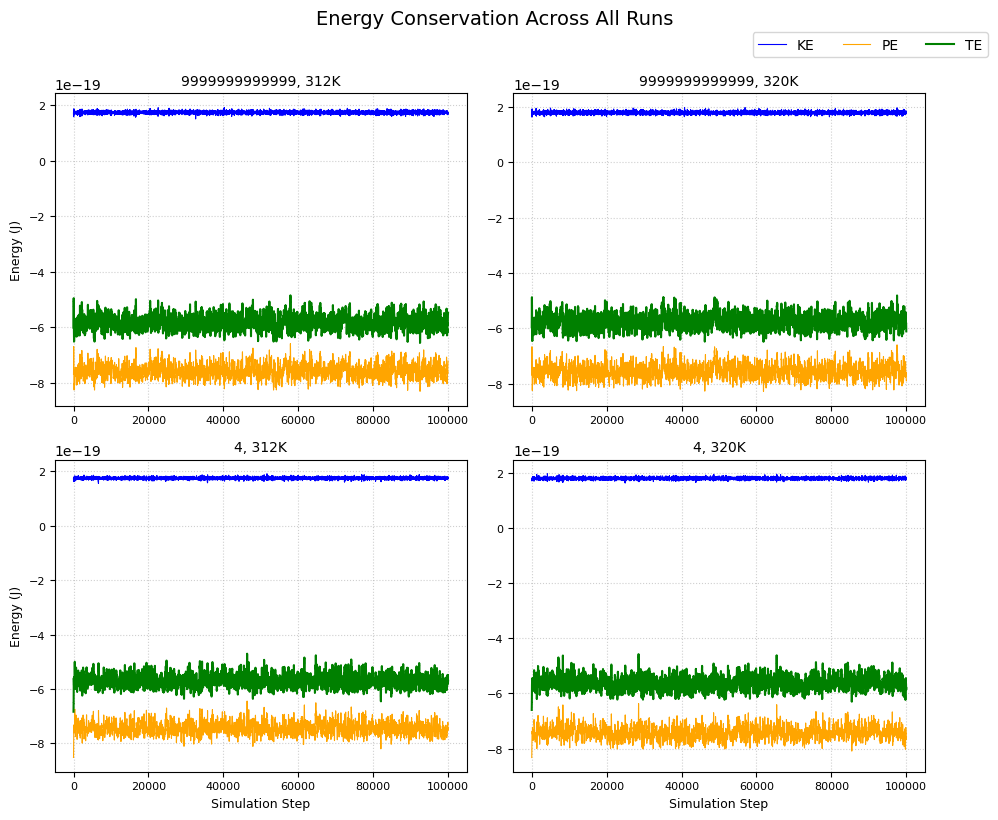

In [ ]:
# Infer dimensions from your stored lists
num_ratio = len(all_kin_energy)
num_temps = len(all_kin_energy[0])

fig, axes = plt.subplots(num_ratio, num_temps, figsize=(10, 8))
axes = axes.reshape(num_ratio, num_temps) # Ensure axes array is 2D

for r_idx in range(num_ratio):
    for t_idx in range(num_temps):
        ax = axes[r_idx, t_idx]
        
        # Get data for this run
        TE_data = all_tot_energy[r_idx][t_idx]
        KE_data = all_kin_energy[r_idx][t_idx]
        PE_data = all_pot_energy[r_idx][t_idx]
        
        if len(TE_data) > 0:
            # Plot data
            ax.plot(KE_data, label='KE', linewidth=0.8, color='blue')
            ax.plot(PE_data, label='PE', linewidth=0.8, color='orange')
            ax.plot(TE_data, label='TE', linewidth=1.5, color='green')
            
            # Set titles and labels
            ax.set_title(f'{molar_ratio_list[r_idx]}, {temperatures_list[t_idx]}K', fontsize=10)
            ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.grid(True, linestyle=':', alpha=0.6)
            
            if r_idx == num_ratio - 1: # Label x-axis on bottom row
                ax.set_xlabel('Simulation Step', fontsize=9)
            
            if t_idx == 0: # Label y-axis on left column
                ax.set_ylabel('Energy (J)', fontsize=9)

# Create a single legend for the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 1.0), ncol=3, fontsize=10)

plt.suptitle('Energy Conservation Across All Runs', y=1.02, fontsize=14)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.savefig('energy_conservation_all_runs.png')

$$\rho_{\text{mix}} = \frac{m_{\text{total}}}{V_{\text{total}}} = \frac{m_{\text{water}} + m_{\text{PO}}}{V_{\text{water}} + V_{\text{PO}}}$$

Now parameters are defined for pure water and propylene oxide systems, the following mixing rules are used to determine the Mie parameters when considering water-propylene oxide interactions. [CARMELO REFERENCE]

$$\sigma_{ij} = \frac{\sigma_i + \sigma_j}{2}$$
$$\epsilon_{ij} = \left( \frac{\sqrt{\sigma_i^3 \sigma_j^3}}{\sigma_{ij}^3} \right) \sqrt{\epsilon_i \epsilon_j}$$
$$\lambda_{ij} = 3 + \sqrt{(\lambda_i - 3)(\lambda_j - 3)}$$

$$E_k = \sum_{i=1}^{N} \frac{1}{2} m_i |\vec{v}_i|^2 \qquad T_{\text{inst}} = \frac{2 E_k}{3 N k_B}$$

Velocity Half-Step ($\vec{v} \rightarrow \vec{v}'$):$$ \\ \vec{v}\left(t + \frac{1}{2}\Delta t\right) = \vec{v}(t) + \frac{\vec{F}(t)}{2m} \Delta t$$

Position Full-Step ($\vec{r} \rightarrow \vec{r}'$): $$ \\ \vec{r}(t + \Delta t) = \vec{r}(t) + \vec{v}\left(t + \frac{1}{2}\Delta t\right) \Delta t$$

Velocity Half-Step ($\vec{v}' \rightarrow \vec{v}''$): (This uses the new force $\vec{F}(t + \Delta t)$ calculated from the new positions).$$ \\ \vec{v}(t + \Delta t) = \vec{v}\left(t + \frac{1}{2}\Delta t\right) + \frac{\vec{F}(t + \Delta t)}{2m} \Delta t$$


INSERT THE TAIL CORRECTION MATHS

1. Pretend the Box is Endless
Imagine your toys are in a tiny playpen. When a car hits one wall, it "teleports" to the other side. That's confusing!

So, we pretend the playpen is a giant, endless floor. When the car hits the wall, we just let it keep going, tracking its real path. This is called "unwrapping."

2. Take Lots of Pictures
Every few seconds, we take a picture (snapshot) of where all the toys are on this giant floor.

Then, we compare the newest picture to all the old pictures. We ask:

"How far did the red car move in 1 second?"

"How far did it move in 2 seconds?"

"How far did it move in 3 seconds?"

We do this for all the toys and for all the pictures, and then we average them. This gives us the Mean Squared Displacement (MSD), which is just a fancy name for the "average wiggles."

3. Find the "Wiggle Speed"
We get a chart that shows "how long" vs. "how much wiggle."

At the start, the toys are just "vrooming" (ballistic), so we ignore that part.

At the very end, we're running out of pictures, so we ignore that too.

We just look at the "boring" middle part, where the toys are bumping around randomly. We draw a straight line through it.

The steepness of that line tells us the "wiggle speed" (the diffusion, D). A steep line means the toys are zipping all over the place!